In [45]:
import pandas as pd
import numpy as np 
import itertools
import keras
import os
import zipfile
import requests
import tensorflow as ts
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense,BatchNormalization,Conv2D,MaxPool2D
from keras import applications 
from keras.utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

In [46]:
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 32

In [47]:
def get_generator(path):
    generator = datagen.flow_from_directory( 
        path, 
        target_size=(img_width, img_height), 
        batch_size=batch_size, 
        class_mode="categorical", 
        shuffle=False) 

    nb_samples = len(generator.filenames) 
    num_classes = len(generator.class_indices) 

    predict_size_train = int(math.ceil(nb_samples / batch_size)) 
    # get the class labels for the training data, in the original order 
    labels = generator.classes 

    # convert the training labels to categorical vectors 
    labels = to_categorical(labels, num_classes=num_classes)
    return (generator,nb_samples,predict_size_train,labels)

In [48]:
datagen = ImageDataGenerator(rescale=1. / 255) 

In [49]:
generator_train,nb_train_samples,predict_size_train,train_labels = get_generator(train_data_dir)
generator_test,nb_test_samples,predict_size_test,test_labels    = get_generator(test_data_dir)
num_classes = 3
class_labels=list(generator_train.class_indices.keys())

Found 222 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [50]:
def apply_pretrainedModel(pretrained_model,generator,predict_size):
    return pretrained_model.predict(generator, predict_size)

In [51]:
def cnn_after_pretrainedModel(input_shape):
    model = Sequential() 
    model.add(Flatten(input_shape=input_shape)) 
    model.add(Dense(128, activation=keras.layers.LeakyReLU(alpha=0.3))) 
    model.add(Dropout(0.5)) 
    model.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3))) 
    model.add(Dropout(0.3)) 
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
       optimizer=optimizers.Adam(learning_rate=1e-4),
       metrics=['acc'])
    return model;

In [52]:
def transfer_learning(pretrained_model,epochs=25):
    #Appling Pretrained Model to train and test datasets
    train_data = apply_pretrainedModel(pretrained_model,generator_train,predict_size_train)
    test_data  = apply_pretrainedModel(pretrained_model,generator_test,predict_size_test)
    model      = cnn_after_pretrainedModel(train_data.shape[1:])
    history = model.fit(train_data, train_labels, 
       epochs=epochs,
       batch_size=batch_size, 
       validation_data=(test_data, test_labels))
    (eval_loss, eval_accuracy) = model.evaluate( 
        test_data, test_labels, batch_size=batch_size,     verbose=1)
    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
    print("[INFO] Loss: {}".format(eval_loss))
    
    return train_data,test_data,model,history,eval_accuracy

In [53]:
def plot_graphs(history):
    #Graphing our training and validation
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy') 
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [54]:
#Loading Pre-trained Model
model_name="VGG"
pretrained_model_vgg  = applications.VGG16(include_top=False, weights='imagenet')
train_data,test_data,model_vgg,history_vgg,acc_vgg = transfer_learning(pretrained_model_vgg)
print()


C:\Users\bmvk1\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Epoch 1/25


C:\Users\bmvk1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\bmvk1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc: 0.3533 - loss: 1.3561 - val_acc: 0.6333 - val_loss: 0.8945
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.5224 - loss: 0.9699 - val_acc: 0.8167 - val_loss: 0.7359
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.6815 - loss: 0.7634 - val_acc: 0.9500 - val_loss: 0.5891
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.6982 - loss: 0.7345 - val_acc: 0.9167 - val_loss: 0.5119
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8156 - loss: 0.5607 - val_acc: 0.9667 - val_loss: 0.4018
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8625 - loss: 0.4671 - val_acc: 0.9667 - val_loss: 0.3202
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.8504 - loss: 0.4236 - val_acc: 0.9667 - val_loss: 0.2627
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8789 - loss: 0.3614 - val_acc: 0.9833 - val_loss: 0.2304
Epoch 9/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.9424 - loss: 0.2803 - val_acc: 1.

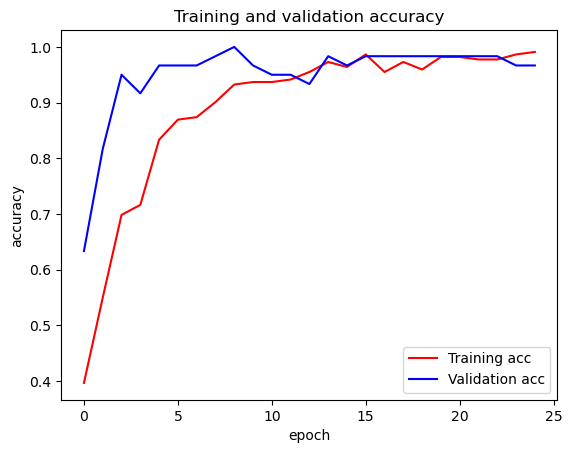

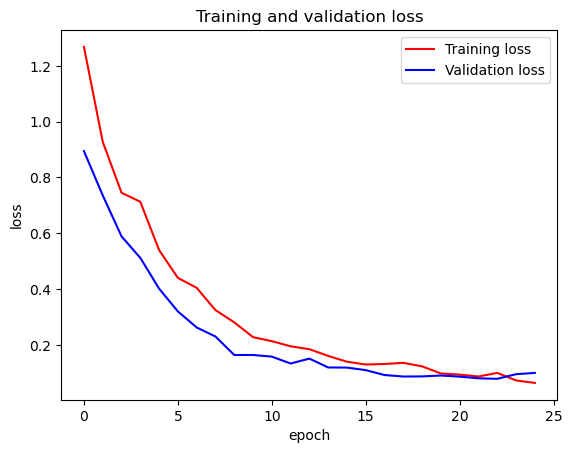

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [55]:
plot_graphs(history_vgg)
preds=np.round(model_vgg.predict(test_data),0)

In [56]:
classify_matrics_vgg=metrics.classification_report(test_labels,preds,target_names=class_labels)
print(classify_matrics_vgg)

              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00        20
      NORMAL       1.00      0.85      0.92        20
   PNEUMONIA       0.91      1.00      0.95        20

   micro avg       0.97      0.95      0.96        60
   macro avg       0.97      0.95      0.96        60
weighted avg       0.97      0.95      0.96        60
 samples avg       0.95      0.95      0.95        60



C:\Users\bmvk1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
#Loading Pre-trained Model
model_name="INCEPTION NET"
pretrained_model_googleNet  = applications.InceptionV3(include_top=False, weights='imagenet')
train_data,test_data,model_googleNet,history_googleNet,acc_googleNet = transfer_learning(pretrained_model_googleNet)

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step
Epoch 1/25


C:\Users\bmvk1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\bmvk1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - acc: 0.3925 - loss: 2.7803 - val_acc: 0.8500 - val_loss: 0.4690
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.6184 - loss: 1.2865 - val_acc: 0.8667 - val_loss: 0.4034
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.7246 - loss: 0.7190 - val_acc: 0.8500 - val_loss: 0.3756
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.7492 - loss: 0.7137 - val_acc: 0.8333 - val_loss: 0.4269
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.8153 - loss: 0.5831 - val_acc: 0.8500 - val_loss: 0.3733
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8532 - loss: 0.4462 - val_acc: 0.8500 - val_loss: 0.3834
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8372 - loss: 0.4258 - val_acc: 0.8167 - val_loss: 0.4351
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8590 - loss: 0.3384 - val_acc: 0.8000 - val_loss: 0.5132
Epoch 9/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9152 - loss: 0.2184 - val_acc: 0.

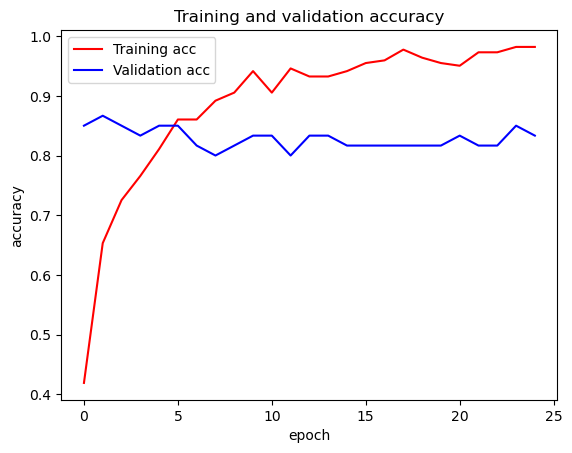

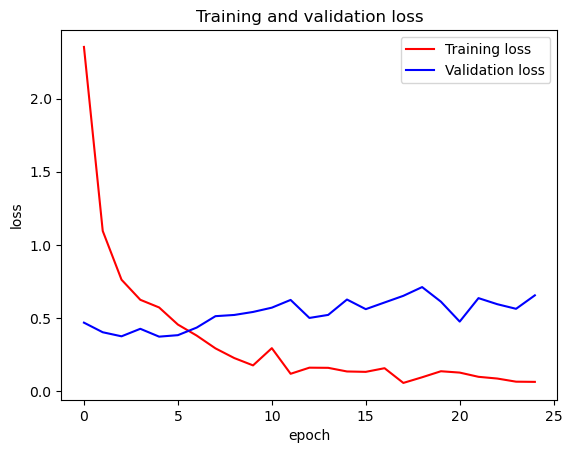

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [58]:
plot_graphs(history_googleNet)
preds=np.round(model_googleNet.predict(test_data),0)

In [59]:
classify_matrics_googleNet=metrics.classification_report(test_labels,preds,target_names=class_labels)
print(classify_matrics_googleNet)

              precision    recall  f1-score   support

       COVID       0.95      0.90      0.92        20
      NORMAL       0.81      0.65      0.72        20
   PNEUMONIA       0.76      0.95      0.84        20

   micro avg       0.83      0.83      0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60
 samples avg       0.83      0.83      0.83        60



In [60]:
#Loading Pre-trained Model
model_name="INCEPTION NET"
pretrained_model_resNet  = applications.ResNet50(include_top=False, weights='imagenet')
train_data,test_data,model_resNet,history_resNet,acc_resNet= transfer_learning(pretrained_model_resNet)

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 649ms/step
Epoch 1/25


C:\Users\bmvk1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\bmvk1\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - acc: 0.3230 - loss: 1.3580 - val_acc: 0.3333 - val_loss: 1.0974
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.3369 - loss: 1.1779 - val_acc: 0.3167 - val_loss: 1.0786
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.3184 - loss: 1.1577 - val_acc: 0.3333 - val_loss: 1.0781
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.3719 - loss: 1.0983 - val_acc: 0.5000 - val_loss: 1.0656
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - acc: 0.4653 - loss: 1.0477 - val_acc: 0.4667 - val_loss: 1.0566
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.3766 - loss: 1.0910 - val_acc: 0.4500 - val_loss: 1.0510
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.5001 - loss: 1.0519 - val_acc: 0.5333 - val_loss: 1.0272
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.4384 - loss: 1.0478 - val_acc: 0.7500 - val_loss: 1.0055
Epoch 9/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.4444 - loss: 1.0454 - val_acc: 0.

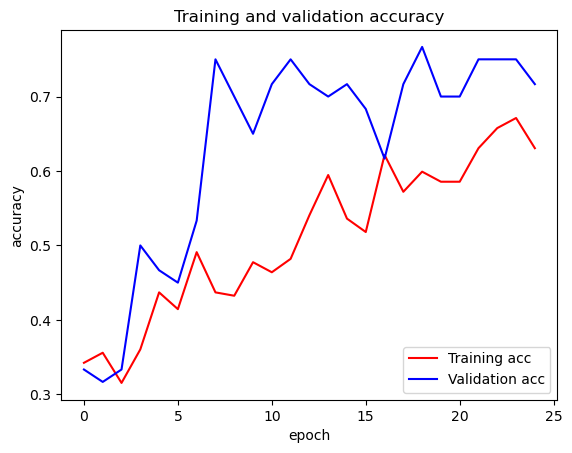

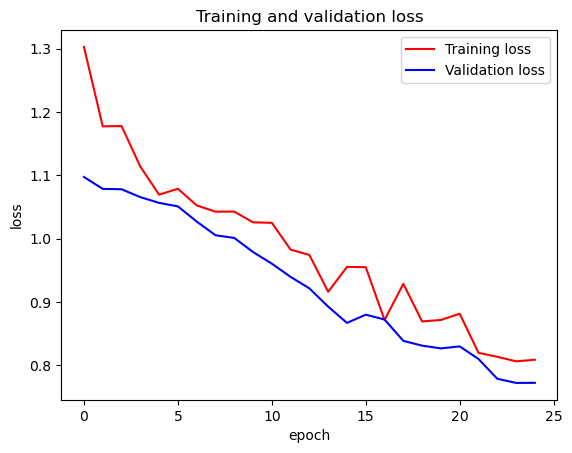

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [61]:
plot_graphs(history_resNet)
preds=np.round(model_resNet.predict(test_data),0)

In [62]:
classify_matrics_resNet=metrics.classification_report(test_labels,preds,target_names=class_labels)
print(classify_matrics_resNet)

              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00        20
      NORMAL       0.60      0.60      0.60        20
   PNEUMONIA       0.00      0.00      0.00        20

   micro avg       0.80      0.53      0.64        60
   macro avg       0.53      0.53      0.53        60
weighted avg       0.53      0.53      0.53        60
 samples avg       0.53      0.53      0.53        60



C:\Users\bmvk1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bmvk1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
print("Accuracies of Models")
print("VGG\t\t",acc_vgg)
print("Google Net\t",acc_googleNet)
print("ResNet\t\t",acc_resNet)

Accuracies of Models
VGG		 0.9666666388511658
Google Net	 0.8333333134651184
ResNet		 0.7166666388511658


In [64]:
def read_image(file_path):
   print("[INFO] loading and preprocessing image…") 
   image = load_img(file_path, target_size=(img_width, img_height))
   image = img_to_array(image) 
   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image

[INFO] loading and preprocessing image…
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
ID: 0, Label: COVID 0.0%
ID: 1, Label: Normal 83.13%
ID: 2, Label: Pneumonia 16.87%
Final Decision:
.
..
...
ID: 1, Label: NORMAL


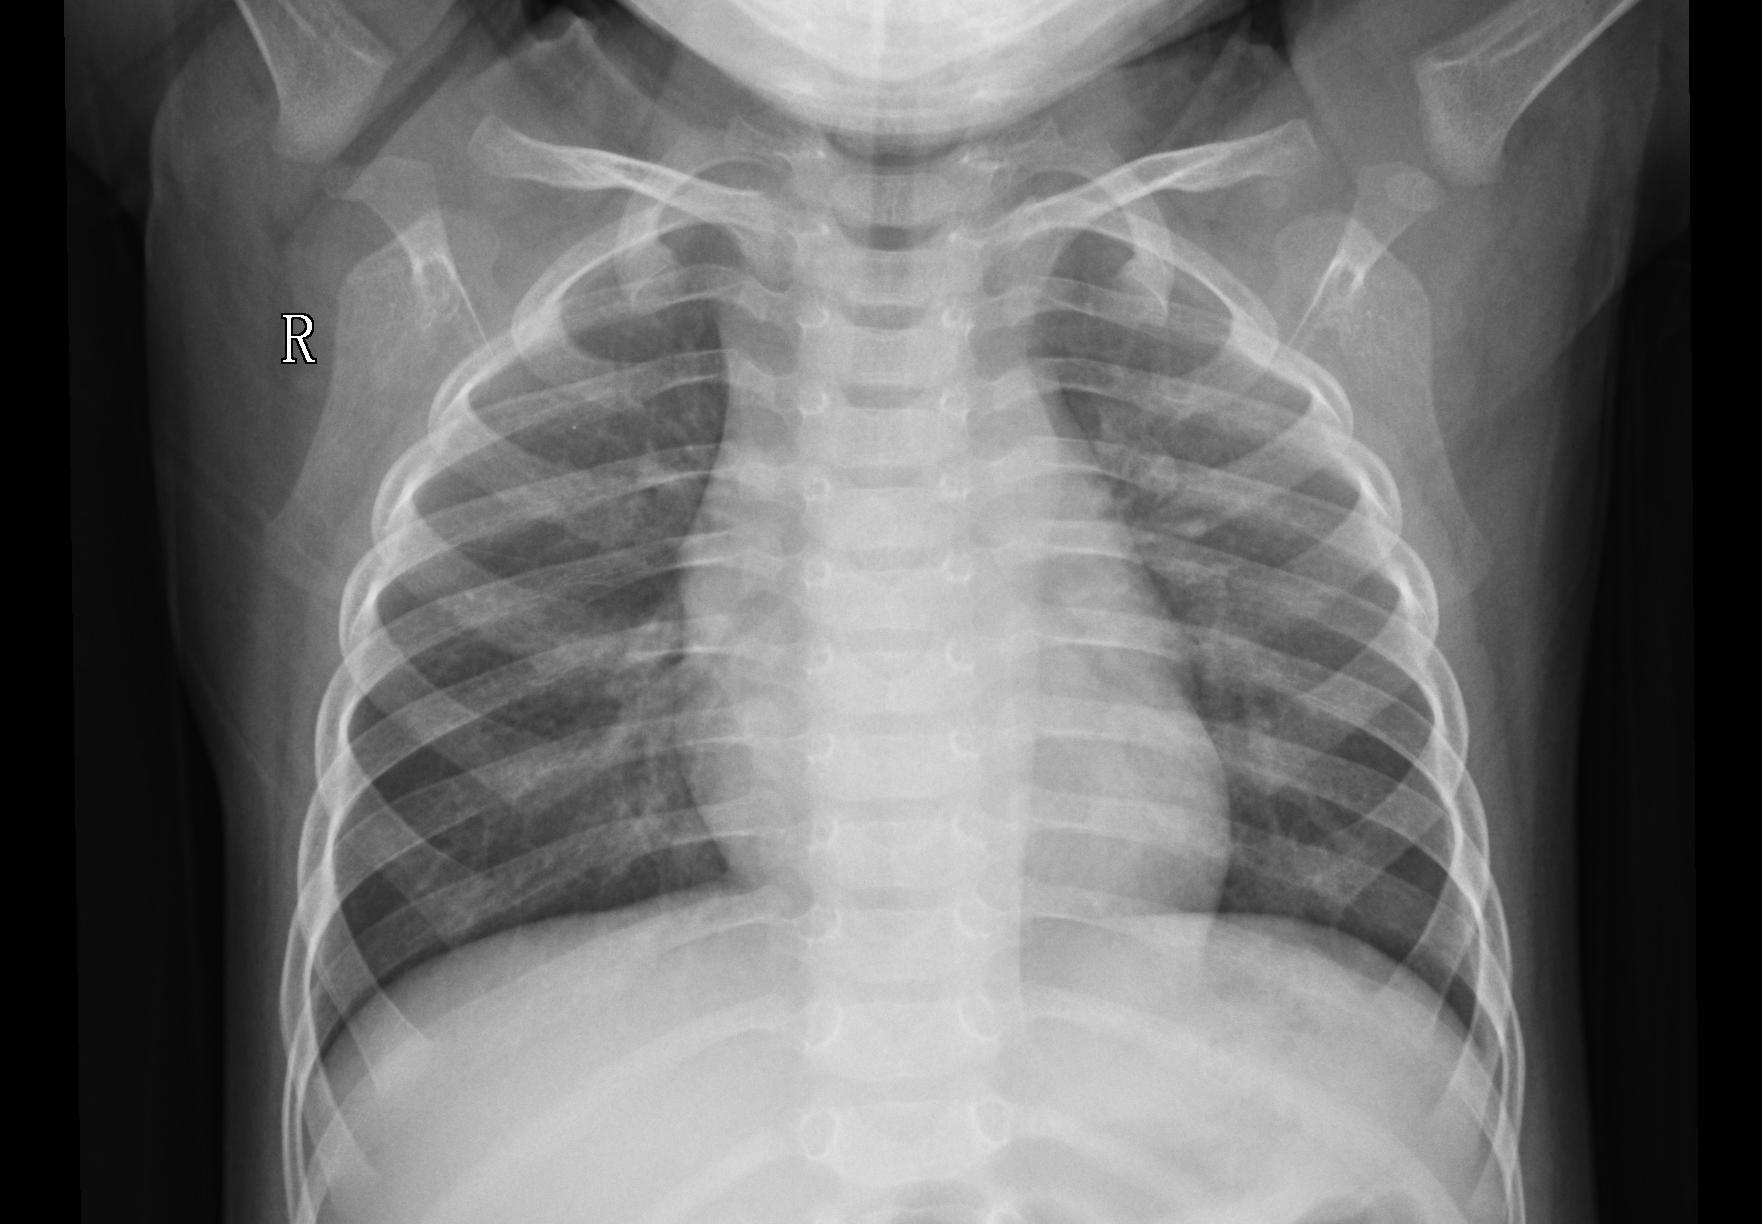

In [65]:
def test_single_image(pretrained_model, model, path, class_labels, generator_test):
    # Load and preprocess the image
    images = read_image(path)
    time.sleep(0.5)
    
    # Get predictions from the pretrained model
    bt_prediction = pretrained_model.predict(images)
    
    # Get predictions from the final model
    preds = model.predict(bt_prediction)
    
    # Display predictions for each class
    for idx, (animal, x) in enumerate(zip(class_labels, preds[0])):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x * 100, 2)))
    
    print('Final Decision:')
    time.sleep(0.5)
    
    for x in range(3):
        print('.' * (x + 1))
        time.sleep(0.2)
    
    # Get the predicted class index (this should be an integer)
    class_predicted = np.argmax(preds, axis=1)[0]  # Extract the first element to make it an integer
    
    # Get the class indices dictionary
    class_dictionary = generator_test.class_indices
    inv_map = {v: k for k, v in class_dictionary.items()}
    
    # Output the final prediction
    predicted_class_name = inv_map[class_predicted]
    print("ID: {}, Label: {}".format(class_predicted, predicted_class_name))
    
    # Load and return the image
    return load_img(path)

# Example usage
path = r'D:\nocovid.jpeg'
class_labels = ['COVID', 'Normal', 'Pneumonia']  # Replace with your actual class labels
test_single_image(pretrained_model_googleNet, model_googleNet, path, class_labels, generator_test)
